In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import trimesh

import postprocess_dataset
from utils import utils
from utils import visualization_tools
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1

In [6]:
def eval_metrics(input_img, rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch, device, metrics_to_eval=["2d_iou", "3d_iou", "3d_iou_norm", "chamfer_L1", "chamfer_L1_norm"],
                 pred_azim=None, pred_elev=None, pred_dist=None):
    
    all_metrics_list = ["2d_iou", "3d_iou", "3d_iou_norm", "chamfer_L1", "chamfer_L1_norm"]
    for metric in metrics_to_eval:
        if metric not in all_metrics_list:
            raise ValueError("Metric {} is unknown.".format(metric))
    
    metrics_dict = {metric:0 for metric in all_metrics_list}
    if "2d_iou" in metrics_to_eval:
        # TODO: not sure if using the original pred pose for the processed iou is legitimate
        if pred_azim is not None and pred_elev is not None and pred_dist is not None:
            metrics_dict["2d_iou"] = compute_iou_2d_given_pose(rec_mesh_torch, input_img, device, pred_azim, pred_elev, pred_dist)
        else:
            metrics_dict["2d_iou"] = compute_iou_2d(rec_mesh_torch, input_img, device)
    if "3d_iou" in metrics_to_eval:
        metrics_dict["3d_iou"] = compute_iou_3d(rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch)
    if "3d_iou_norm" in metrics_to_eval:
        metrics_dict["3d_iou_norm"] = compute_iou_3d(rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch, full_unit_normalize=True)
    if "chamfer_L1" in metrics_to_eval:
        metrics_dict["chamfer_L1"] = compute_chamfer_L1(rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch)
    if "chamfer_L1_norm":
        metrics_dict["chamfer_L1_norm"] = compute_chamfer_L1(rec_mesh, rec_mesh_torch, gt_mesh, gt_mesh_torch, full_unit_normalize=True)
        
    return metrics_dict

In [14]:
# displays meshes at the predicted pose
def show_meshes(input_dir_img, input_dir_mesh, refined_models_dir, gt_shapes_dict, device, only_show_instances=None, num_novel_view=3, metrics_to_eval=["2d_iou", "3d_iou", "3d_iou_norm", "chamfer_L1", "chamfer_L1_norm"]):

    # combining all cached predicted poses
    cached_pred_poses = {}
    pred_pose_paths = list(Path(refined_models_dir).rglob('pred_poses.p'))
    for pred_pose_path in pred_pose_paths:
        curr_cache = pickle.load(open(pred_pose_path, "rb"))
        cached_pred_poses = {**cached_pred_poses, **curr_cache}
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(refined_models_dir).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if only_show_instances is None or instance_name in only_show_instances:
            for processed_mesh_path in processed_paths_dict[instance_name]:
                print(processed_mesh_path)
            
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                original_mesh_path = os.path.join(input_dir_mesh, instance_name+".obj")
                with torch.no_grad():
                    mesh_original = utils.load_untextured_mesh(original_mesh_path, device)
                    mesh_processed = utils.load_untextured_mesh(processed_mesh_path, device)
                mesh_original_trimesh = trimesh.load(original_mesh_path)
                mesh_processed_trimesh = trimesh.load(processed_mesh_path)
                
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                
                # computing performance metrics
                if len(metrics_to_eval) > 0:
                    gt_mesh_path = gt_shapes_dict[instance_name]
                    with torch.no_grad():
                        mesh_gt = utils.load_untextured_mesh(gt_mesh_path, device)
                    mesh_gt_trimesh = trimesh.load(gt_mesh_path)
                    
                    metrics_dict_before = eval_metrics(input_image, mesh_original_trimesh, mesh_original, mesh_gt_trimesh, mesh_gt, device, metrics_to_eval, pred_azim, pred_elev, pred_dist)
                    metrics_dict_after = eval_metrics(input_image, mesh_processed_trimesh, mesh_processed, mesh_gt_trimesh, mesh_gt, device, metrics_to_eval, pred_azim, pred_elev, pred_dist)
                    
                    print("Metrics before refinement -- {}".format(metrics_dict_before))
                    print("Metrics after refinement -- {}".format(metrics_dict_after))
                
                visualization_tools.show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device, num_novel_view)

In [8]:
# occnet reconstructed pix3d chairs
#input_dir_mesh = "data/onet_chair_pix3d_no_DA_simplified"
#input_dir_img = "data/img_pix3d_chair/chair"
#gt_shapes_list_path = "data_evaluation/pix3d_chair/pix3d_chair_gt_shapes.lst"
#exp_name = "gridsearch2"

# occnet reconstructed shapenet chairs
input_dir_mesh = "data/onet_chair_shapent_no_DA_simplified"
input_dir_img = "data/img_shapenet_chair"
gt_shapes_list_path = "data_evaluation/shapenet_chair/shapenet_chair_gt_shapes.lst"
exp_name = "processed"

In [9]:
refined_models_dir = "{}_{}".format(input_dir_mesh, exp_name)
print(refined_models_dir)
device = torch.device("cuda:0")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]

data/onet_chair_shapent_no_DA_simplified_processed


data/onet_chair_shapent_no_DA_simplified_processed/batch_1_of_5/d0500d229baf05b0e83221ad0d21775.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.8699456, '3d_iou_norm': 0.8627567, 'chamfer_L1': 0.00025302739231847227, 'chamfer_L1_norm': 0.0012650866992771626}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.65157586, '3d_iou_norm': 0.58308417, 'chamfer_L1': 0.0022823233157396317, 'chamfer_L1_norm': 0.011664576828479767}


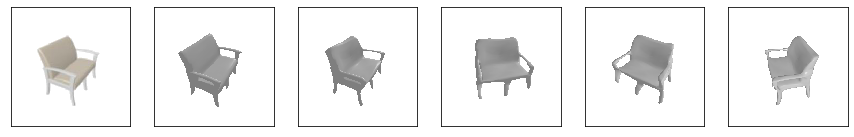

data/onet_chair_shapent_no_DA_simplified_processed/batch_1_of_5/cd5ad4afabaed0d3e762624dc3c8fa2a.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.018026346, '3d_iou_norm': 0.017701184, 'chamfer_L1': 0.005231956485658884, 'chamfer_L1_norm': 0.04142393916845322}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.031828094, '3d_iou_norm': 0.053613845, 'chamfer_L1': 0.003917704336345196, 'chamfer_L1_norm': 0.029105138033628464}


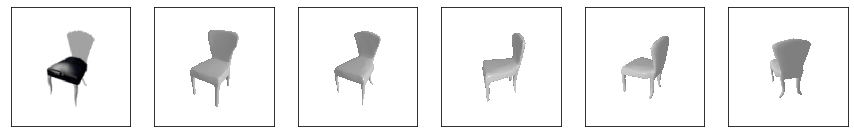

data/onet_chair_shapent_no_DA_simplified_processed/batch_2_of_5/ddfe96c6ec86b8752cbb5ed9636a4451.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.0, '3d_iou_norm': 9.94629e-05, 'chamfer_L1': 0.0011006122222170234, 'chamfer_L1_norm': 0.006462204270064831}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.0, '3d_iou_norm': 0.0, 'chamfer_L1': 0.001111781457439065, 'chamfer_L1_norm': 0.00750532653182745}


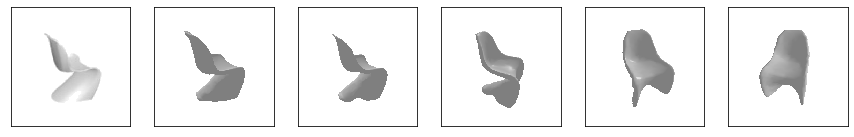

data/onet_chair_shapent_no_DA_simplified_processed/batch_2_of_5/d8ea454fb35e38887b11ae648ea92233.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.67630666, '3d_iou_norm': 0.63647926, 'chamfer_L1': 0.0006263353861868382, 'chamfer_L1_norm': 0.0035076276399195194}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.6260332, '3d_iou_norm': 0.65881515, 'chamfer_L1': 0.0007759511354379356, 'chamfer_L1_norm': 0.003412698395550251}


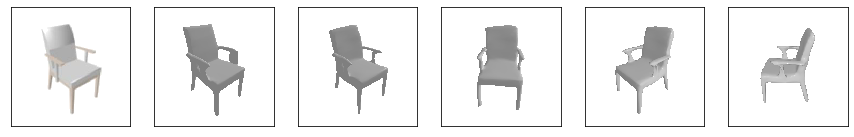

data/onet_chair_shapent_no_DA_simplified_processed/batch_3_of_5/e2acc4d276fda3d77d70172a29ade99a.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.29572216, '3d_iou_norm': 0.18334171, 'chamfer_L1': 0.00416038790717721, 'chamfer_L1_norm': 0.027416419237852097}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.0717367, '3d_iou_norm': 0.080288775, 'chamfer_L1': 0.03082127310335636, 'chamfer_L1_norm': 0.17391341924667358}


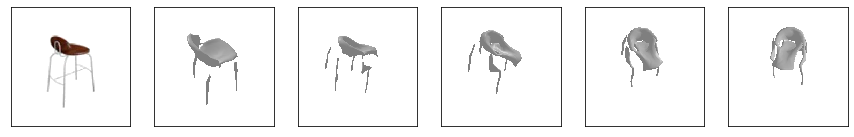

data/onet_chair_shapent_no_DA_simplified_processed/batch_3_of_5/e4a890f2330ebd7e4a11872aa986426d.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.6382491, '3d_iou_norm': 0.5376869, 'chamfer_L1': 0.002103436039760709, 'chamfer_L1_norm': 0.017511099576950073}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.47835517, '3d_iou_norm': 0.48009712, 'chamfer_L1': 0.002600146923214197, 'chamfer_L1_norm': 0.01927819848060608}


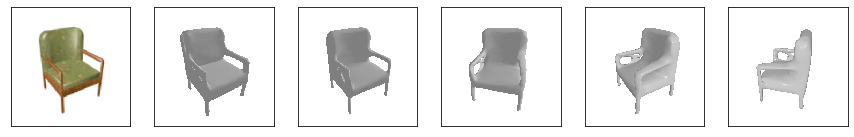

data/onet_chair_shapent_no_DA_simplified_processed/batch_5_of_5/f5d8dd0309401ebac47a35332c17cce2.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.2655261, '3d_iou_norm': 0.254844, 'chamfer_L1': 0.0020447690039873123, 'chamfer_L1_norm': 0.019444623962044716}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.26871616, '3d_iou_norm': 0.21541694, 'chamfer_L1': 0.0015339001547545195, 'chamfer_L1_norm': 0.016216779127717018}


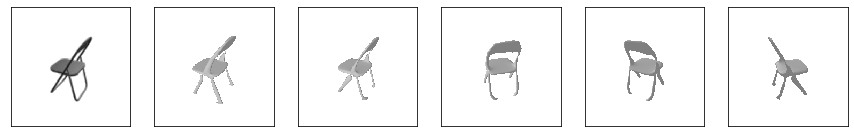

data/onet_chair_shapent_no_DA_simplified_processed/batch_5_of_5/fa8860d6a0d45a4688dcbe86402c7c15.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.6149763, '3d_iou_norm': 0.5302411, 'chamfer_L1': 0.0005107633187435567, 'chamfer_L1_norm': 0.009810883551836014}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.4768416, '3d_iou_norm': 0.47783074, 'chamfer_L1': 0.0007570133311673999, 'chamfer_L1_norm': 0.017026258632540703}


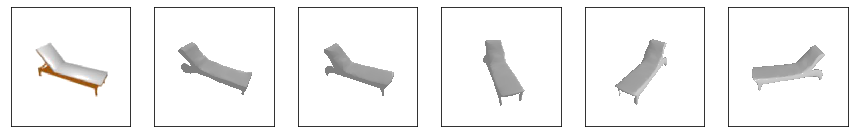

data/onet_chair_shapent_no_DA_simplified_processed/batch_4_of_5/ecbb4e4665c7fbb45613f5c2df1029a.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.043456543, '3d_iou_norm': 0.047279604, 'chamfer_L1': 0.001128224190324545, 'chamfer_L1_norm': 0.008983805775642395}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.013853017, '3d_iou_norm': 0.012059494, 'chamfer_L1': 0.004218333400785923, 'chamfer_L1_norm': 0.021605318412184715}


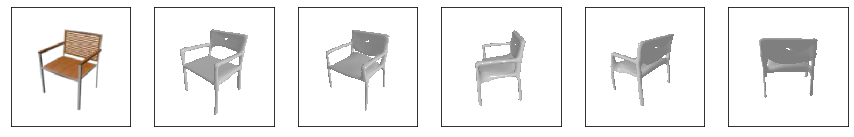

data/onet_chair_shapent_no_DA_simplified_processed/batch_4_of_5/ed97d1c954fca49851ceffe90913a32.obj
Metrics before refinement -- {'2d_iou': 0, '3d_iou': 0.68012047, '3d_iou_norm': 0.68906754, 'chamfer_L1': 0.0004412891576066613, 'chamfer_L1_norm': 0.004803712945431471}
Metrics after refinement -- {'2d_iou': 0, '3d_iou': 0.43185228, '3d_iou_norm': 0.38297477, 'chamfer_L1': 0.001750220195390284, 'chamfer_L1_norm': 0.028622262179851532}


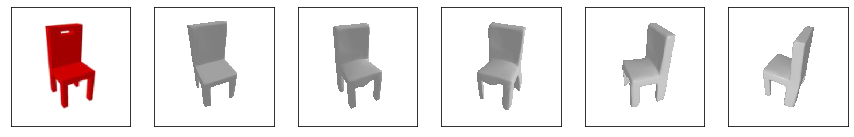

In [18]:
# show postprocessed meshes at predicted angle
instances = random.sample([str(path).split('/')[-1].replace('.obj',"") for path in list(Path(refined_models_dir).rglob('*.obj'))], 10)
#instances = ["0085", "0151", "0281", "0356", "0372", "0409", "0578", "0596", "0702", "0737"]
#instances = ["0085", "0281"]

#m = ["2d_iou", "3d_iou", "3d_iou_norm", "chamfer_L1", "chamfer_L1_norm"]
m = ["3d_iou", "3d_iou_norm", "chamfer_L1", "chamfer_L1_norm"]
show_meshes(input_dir_img, input_dir_mesh, refined_models_dir, gt_shapes_dict, device, only_show_instances=instances, metrics_to_eval=m)

In [ ]:
# show training loss info
# getting paths of all loss info pickled files
input_dir_mesh = cfg['dataset']['input_dir_mesh']
output_dir = "{}_{}".format(input_dir_mesh, exp_name)
cached_loss_info_paths = list(Path(output_dir).rglob('loss_info.p'))

for path in cached_loss_info_paths:
    dataset_loss_info = pickle.load(open(path, "rb"))
    for instance_name in dataset_loss_info:
        loss_info = dataset_loss_info[instance_name]
        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
        #loss_info.plot.line(x='iteration', y='sil_loss')
        #loss_info.plot.line(x='iteration', y='img_sym_loss')
        #loss_info.plot.line(x='iteration', y='vertex_sym_loss')
        #loss_info.plot.line(x='iteration', y='l2_loss')
        #loss_info.plot.line(x='iteration', y='lap_smoothness_loss')
        #loss_info.plot.line(x='iteration', y='normal_consistency_loss')
        #loss_info.plot.line(x='iteration', y='semantic_dis_loss')